<a href="https://colab.research.google.com/github/Ele975/LLM_from_scratch/blob/main/Fine_tuning_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description model fine-tuning for classification (spam detection)
In general LLMs are not used for tasks such as spam detection, however this is for demonstration purposes with a simple task (they can be used if the spam detection mechanism should be very precise and the email are complex).

After the pretraining where the model learns how to perdict next tokens in a coherent way, LLMs can be fine-tuned to perform required task such as classification, question answering, sentiment analysis, text generation, etc. The fine-tuning can be divided into:
1. **fine-tuning for classification**: perform classification given an input such as spam detection, element recognition given images (tumors, object detection), text classification, etc. More specific than other fine-tuning since it is specialized in performing only the classification it saw only during the training phase

2. **fine-tuning to follow instruction**: fine-tune model such that given some instructions (in form of prompts) in natural language it is able to understand and execute the required different tasks. E.g. "**Translate in German** 'text to translate' ". Can perform different tasks

# Import data

In [1]:
# for tokenizer
!pip install tiktoken

# for weights loading
!pip install tensorflow>=2.15.0
!pip install tqdm>=4.66

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.6 MB/s eta 0:00:00


In [2]:
import re
import urllib.request
import tiktoken
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import pandas as pd
import torch
import time
import json
import psutil

from torch.utils.data import Dataset
from functools import partial
from pathlib import Path
from matplotlib.ticker import MaxNLocator
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Preprocessing

## Pretraining functions

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,   # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
}

BPE tokenizer

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")

Self attention class with causal mask component and dropout

In [5]:
class CausalAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
    super().__init__()
    self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)

    # mask has size context_length x context_length since we need to store the attention scores and attention weights for each token before the current one (lower triangular matrix)
    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length, diagonal=1)))

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    values = self.W_value(x)
    queries = self.W_query(x)

    # transpose last two dimensions of keys to enable matrix multiplication -> from (batch_size, tokens_nr, embedding_dim) to (batch_size, embedding_dim, )
    attn_scores = queries @ keys.transpose(1,2)
    # access the mask above saved as buffer -> not optimized during backpropagation but available during the forward pass (often with masks)
    attn_scores.masked_fill(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)
    context_vec = attn_weights @ values
    return context_vec





Multi-head attention mechanism

Multiple queries, keys and values in parallel permits to compute different attention weights and attention scores. The resulting context vectors are then concatenated.

In [6]:
class MultiHeadAttentionWrapper(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    # create the desired number of heads using the class above that generates a single causal attention head
    self.heads = nn.ModuleList([CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)])

  def forward(self, x):
    # head(x) call the forward method of the class CausalAttention and returns the context vectors for a single head
    return torch.cat([head(x) for head in self.heads], dim=-1)

In [7]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    # the inputs are multiplied by the matrices Q,K,V generating the reduced q,v,k which have the same dimension of the output context vector.
    # For the parallel computation, q,v,k are split across the multiple heads, thus the dimension of q,v,k should be at least # heads
    assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.out_proj = nn.Linear(d_out, d_out)

    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # view = reshape from [b, num_tokens, d_in] to [b, num_tokens, self.num_heads, self.head_dim] -> dimensions of k,q,v for each head
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)

    # transpose in order to compute separately the results for each head, pass from [b, num_tokens, self.num_heads, self.head_dim] to [b, num_tokens, self.head_dim, self.num_heads]
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2)

    attn_scores = queries @ keys.transpose(2,3)
    # not always context_sizes correspond to num_tokens (last batch, last input can have less tokens), thus cut
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    attn_scores.masked_fill_(mask_bool, -torch.inf)

    attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
    attn_weights = self.dropout(attn_weights)

    # transpose again to pass from [b, num_tokens, self.head_dim, self.num_heads] to [b, self.head_dim, num_tokens, self.num_heads]
    # permit to concanenate easier the results of the different heads
    context_vec = (attn_weights @ values).transpose(1, 2)

    # combine head results
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

    # raw concatenation is not enough for the models, thus this is used to refine the concatenation. Not mandatory but commonly used
    context_vec = self.out_proj(context_vec)
    return context_vec


Functions to convert from tokens to tokens IDs and opposite (the model outputs are token IDs)

In [8]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  # insert batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  # remove batch dimension
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

GPT model architecture

In [9]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
      mean = x.mean(dim=-1, keepdim=True)
      var = x.var(dim=-1, keepdim=True, unbiased=False)
      norm_x = (x - mean) / torch.sqrt(var + self.eps)
      return self.scale * norm_x + self.shift

In [10]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

In [11]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                                GELU(),
                                nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),)

  def forward(self, x):
    return self.layers(x)

In [12]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    # normalize the embedding dimension
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    # save input for attention shortcut
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    # shortcut for FNN
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

In [13]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

Simple version without text originality (used in the model traning)

In [14]:
# idx -> input with size (batch, token ids)
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    # crops current context size to supported context size by the model -> if model supports size 5 and context size is 10, maintain last 5 tokens as context
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    # output of model is (batch, token, vocab), thus take last token
    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    # get idx of the next token that will be part of the next input given to the model
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)
    idx = torch.cat((idx, idx_next), dim=1)
  return idx


Load pretrained GPT2 weights

In [15]:
# get gpt_download.py

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7a993c8bac50>)

Load GPT-2 architecture settings and parameters

In [16]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 106kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 660kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 156kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:06<00:00, 7.43MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 7.88MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 382kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 373kiB/s]


All configurations for GPT-2 models (small, medium, large, xl)

In [17]:
model_configs = {
  "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
  "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
  "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
  "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

Function to check that left and right tensors have same shape (check if assignment of data is correct)

In [18]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}, " "Right: {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

Assign loaded parameters to the new model with the new configuration. Complex function and based on some guessing since GPT used different names. It is possible to load the pretrained GPT model without manually assign all parameters, but this is for demonstration purpose (i.e. model = GPT2Model.from_pretrained("gpt2"))

In [19]:
def load_weights_into_gpt(gpt, params):
  # assign positional and token embeddings
  gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
  gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

  # iteration over all transformer blocks
  for b in range(len(params["blocks"])):
    # query, key and value components for self attention mechanism
    # split concatenated weights for q,k,v into 3 components q_w, k_w, v_w, transpose and assign
    q_w, k_w, v_w = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.weight = assign(
        gpt.trf_blocks[b].att.W_query.weight, q_w.T)
    gpt.trf_blocks[b].att.W_key.weight = assign(
        gpt.trf_blocks[b].att.W_key.weight, k_w.T)
    gpt.trf_blocks[b].att.W_value.weight = assign(
        gpt.trf_blocks[b].att.W_value.weight, v_w.T)

    # same for biases
    q_b, k_b, v_b = np.split(
        (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.bias = assign(
        gpt.trf_blocks[b].att.W_query.bias, q_b)
    gpt.trf_blocks[b].att.W_key.bias = assign(
        gpt.trf_blocks[b].att.W_key.bias, k_b)
    gpt.trf_blocks[b].att.W_value.bias = assign(
        gpt.trf_blocks[b].att.W_value.bias, v_b)

    # output projection
    gpt.trf_blocks[b].att.out_proj.weight = assign(
        gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].att.out_proj.bias = assign(
        gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])

    # feedforward nn
    gpt.trf_blocks[b].ff.layers[0].weight = assign(
        gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ff.layers[0].bias = assign(
        gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
    gpt.trf_blocks[b].ff.layers[2].weight = assign(
        gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ff.layers[2].bias = assign(
        gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

    # layer normalization, where scale='g' for gain and shift='b' for bias
    gpt.trf_blocks[b].norm1.scale = assign(
        gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(
        gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
    gpt.trf_blocks[b].norm2.scale = assign(
        gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(
        gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])

  # final layer normalization and output head
  gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
  gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
  gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

## Fine-tuning preprocessing

Download dataset for spam detection

In [20]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
# name of downloaded file
zip_path = "sms_spam_collection.zip"
# where the unzipped file is stored
extracted_path = "sms_spam_collection"
# create path pointing to sms_spam_collection appending SMSSpamCollection to the path -> after the unzip the dataset will be called SMSSpamCollection.tsv
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

tokenizer = tiktoken.get_encoding("gpt2")

In [21]:
def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
  if data_file_path.exists():
    print(f"{data_file_path} already exists. Skipping download and extraction.")
    return
  # download file (write in zip_path the file read from url contained in 'response')
  with urllib.request.urlopen(url) as response:
    with open(zip_path, "wb") as out_file:
        out_file.write(response.read())
  # unzip file
  with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extracted_path)
  # add .tsv file extension
  original_file_path = Path(extracted_path) / "SMSSpamCollection"
  # add .tsv extension
  os.rename(original_file_path, data_file_path)
  print(f"File downloaded and saved as {data_file_path}")


In [22]:
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


Load .tsv file in a dataframe

In [23]:
# /t since it it tab-separated (TSV) to know how to separate columns
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"] )
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [24]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


Simple dataset balancing since the two classes 'spam' and 'ham' have very different sizes -> done to avoid class bias and improve generalization (not performant with the small classes)

In [25]:
def create_balanced_dataset(df):
  num_spam = df[df["Label"] == 'spam'].shape[0]
  # sample randomly num_spam number of ham data to balance the two classes. Ensure reproducibility with random_state
  ham_subset = df[df["Label"] == 'ham'].sample(num_spam, random_state=123)
  # concatenate new column of the ham subset with all spam
  balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
  return balanced_df

In [26]:
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


Convert labels into integers 0 and 1

In [27]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

Split data in dataset randomly in training set (70%), validation set (10%), test set (20%)

In [28]:
def random_split(df, train_frac, validation_frac):
  # sample randomly data, since we take frac=1, we simply shuffle them. Drop old indices and reset them
  df = df.sample(frac=1, random_state=123).reset_index(drop=True)
  # get indices of split
  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)

  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]

  return train_df, validation_df, test_df


In [29]:
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

Save datasets as CSV

In [30]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

Create data loaders -> for the pretraining we had a sliding window that permit to had sentences of the same length, but in emails the lengths are different, thus:
1. truncate all messages to the length of the shortest one -> cheaper but there is the possibility of information loss if the shortest message is really short

2. add padding to all messages reaching the length of the longest one -> expensive but preserve information -> in this case we use this option with "<|endoftext|>" as padding token


In [31]:
class SpamDataset(Dataset):
  def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
    self.data = pd.read_csv(csv_file)
    self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
    if max_length is None:
      self.max_length = self._longest_encoded_length()
    else:
      self.max_length = max_length
    self.encoded_texts = [encoded_text[:self.max_length]for encoded_text in self.encoded_texts]
    self.encoded_texts = [encoded_text + [pad_token_id] *(self.max_length - len(encoded_text))for encoded_text in self.encoded_texts]

  def __getitem__(self, index):
    encoded = self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]
    return (torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long))

  def __len__(self):
    return len(self.data)

  def _longest_encoded_length(self):
    max_length = 0
    for encoded_text in self.encoded_texts:
      encoded_length = len(encoded_text)
      if encoded_length > max_length:
        max_length = encoded_length
    return max_length


Pad train, test and validation sets

In [32]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

In [33]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [34]:
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [35]:
print(train_dataset.max_length)

120


Generate data loader -> each batch contains 8 input, where an input is an email text of 120 tokens and the label is 0 or 1 depending if spam or not

In [36]:
num_workers = 0
batch_size = 8
torch.manual_seed(123)

In [37]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

In [38]:
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [39]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

Check batch sizes if correct

In [40]:
for input_batch, target_batch in train_loader:
  pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


Print total batches in each set

In [41]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## Model setup

### Model initialization

In [42]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

In [43]:
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

In [44]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [45]:
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

Download weights into gpt-2 model

In [46]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Check if model outputs coherent text, thus the parameters has been loaded correctly

In [47]:
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


### Classification head
Substitute the original output layer that maps to the vocabulary ('out_head') with a smaller output layer that maps to two classes only: 0 and 1 (not spam or spam). Without fine-tuning, with the new output layer the output of the model will be (batch_size, nr_tokens, vocab_dim), but the vocab_dim instead of being 50257 is now 2 (embedding dim) (for prediction of next token we take into consideration only the last token of the output).

We freeze the model for the fine-tuning in order to not update the parameters -> keep the pre-trained weights intact and only train the new layers or the final layer to adapt the model to a new task or dataset

In [48]:
for param in model.parameters():
  param.requires_grad = False

Change final layer. This one has requires_grad = True automatically, thus this will be the only layer updated during fine-tuning. However despite the fact this should be sufficient, by empirical experiments fine-tuning additional layers improve the performance of the model

In [49]:
torch.manual_seed(123)
num_classes = 2

model.out_head = torch.nn.Linear(
    # = 768, output dimension of transformer blocks
    in_features = BASE_CONFIG["emb_dim"],
    out_features = num_classes,
)

Make trainable last transformer block and final LayerNorm

In [50]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

Consider only last token of the output for the classification. Why? Given the implementation of the attention mask that permit each token to have information about all preceeding tokens in the sequence, the last one is the one with most information. Using the softmax on these two values for each input text we get the probability to be spam or not spam, and we take the highest one as the correct class

### Implement evaluation utilities
Compute classification loss and model accuracy (percentage of correct predictions)

In [51]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
  model.eval()
  correct_predictions, num_examples = 0, 0
  if num_batches is None:
    num_batches = len(data_loader)
  else:
      num_batches = min(num_batches, len(data_loader))

  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      input_batch = input_batch.to(device)
      target_batch = target_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:, -1, :]
      predicted_labels = torch.argmax(logits, dim=-1)
      num_examples += predicted_labels.shape[0]

      correct_predictions += ((predicted_labels == target_batch).sum().item())
    else:
      break
  return correct_predictions / num_examples

function loss: cross-entropy for a single batch

In [52]:
def calc_loss_batch(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)[:, -1, :]
  loss = torch.nn.functional.cross_entropy(logits, target_batch)
  return loss

loss for all batches

In [53]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
  total_loss = 0.
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader)
  else:
    num_batches = min(num_batches, len(data_loader))
  for i, (input_batch, target_batch) in enumerate(data_loader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches

Initial loss

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
  train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)

val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.183
Validation loss: 2.583
Test loss: 2.322


## Model fine-tuning and usage

In [55]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device,num_epochs, eval_freq, eval_iter):
  train_losses, val_losses, train_accs, val_accs = [], [], [], []
  examples_seen, global_step = 0, -1
  for epoch in range(num_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      loss = calc_loss_batch(input_batch, target_batch, model, device)
      loss.backward()
      optimizer.step()

      examples_seen += input_batch.shape[0]
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, "
              f"Val loss {val_loss:.3f}")

    train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
    val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

    print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
  return train_losses, val_losses, train_accs, val_accs, examples_seen


Evaluation: compute loss over training and evaluation sets ensuring model is in evaluation mode without dropout  

In [56]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  # not required in evaluation and save computational space
  with torch.no_grad():
    # compute loss for multiple batches to have more stable evaluation
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    # swap again to training mode for the training process in train_model_simple()
    model.train()
    return train_loss, val_loss

Evaluate the model by taking a text snippet and passing to the model

In [57]:
# start_context = text snippet for evaluation purposes
def generate_and_print_sample(model, tokenizer, device, start_context):
  model.eval()
  # in the positional embedding weights the first shape is the context size
  context_size = model.pos_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    # use the model in order to get the predicted next tokens starting from start_context
    token_ids = generate_text_simple(model=model, idx=encoded,max_new_tokens=50, context_size=context_size)
  decoded_text = token_ids_to_text(token_ids, tokenizer)
  print(decoded_text.replace("\n", " "))
  model.train()

Run fine-tuning computing the time needed

In [58]:
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

In [59]:
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=50,
        eval_iter=5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time)/60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 58.15 m

In [60]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  # plot training and validation values with respect to epochs
  ax1.plot(epochs_seen, train_values, label=f"Training {label}")
  ax1.plot(epochs_seen, val_values, label=f"Validation {label}")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel(label.capitalize())
  ax1.legend()

  # create new x-axis on same plot that overlay x1 but without interfere
  ax2 = ax1.twiny()
  ax2.plot(examples_seen, train_values, alpha=0)
  ax2.set_xlabel("Examples seen")

  # adjust layout to avoid overlap between plot elements
  fig.tight_layout()
  # store plot
  plt.savefig(f"{label}-plot.pdf")
  plt.show()

Plot classification loss

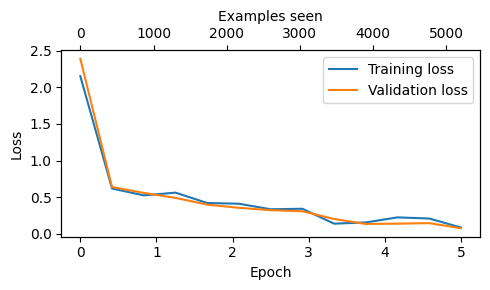

In [61]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Plot classification accuracy

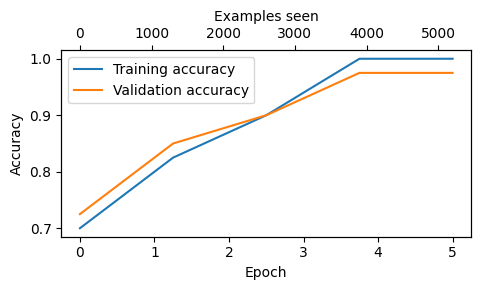

In [62]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

Compute accuracy of entire datasets

In [63]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

In [64]:
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


Use model for email classification with new data

In [65]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
  model.eval()
  input_ids = tokenizer.encode(text)
  # gives the maximum sequence length that can be processed by the model (the one chosen as maximum length for the fine-tuning)
  supported_context_length = model.pos_emb.weight.shape[1]
  # truncate text if needed
  input_ids = input_ids[:min(max_length, supported_context_length)]
  # add padding
  input_ids += [pad_token_id] * (max_length - len(input_ids))

  input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

  with torch.no_grad():
    # get last token with all information
    logits = model(input_tensor)[:, -1, :]
  # get value (0,1) associated with highest probability of last token
  predicted_label = torch.argmax(logits, dim=-1).item()

  return "spam" if predicted_label == 1 else "not spam"


Check prediction

In [66]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

In [67]:
print(classify_review(text_1, model, tokenizer, device, max_length= train_dataset.max_length))
print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

spam
not spam


Save the model

In [68]:
torch.save(model.state_dict(), "review_classifier.pth")